In [166]:
import geopandas as gpd
import pandas as pd
import shapely
import rasterio
import os
from pathlib import Path
import rioxarray
import fiona.transform
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Polygon
import skimage.draw
import numpy as np

In [167]:
def get_year(row):
    
    try:
        
        nums = [int(s) for s in row.split(" ") if s.isdigit()]
        max_value = int(max(nums))
    
    except:
        max_value = None
    
    return max_value


# Function to retrieve the tile geometry, this will be used to extract structures that are covered by the tiles

def get_tile_geom(tile_tif, crs=None):
    
    rds = rioxarray.open_rasterio(tile_tif)
    
    if crs is not None:

        assert isinstance(crs, str)
        
        rds_proj = rds.rio.reproject(crs)
        minx, miny, maxx, maxy = rds_proj.rio.bounds()
        geometry = shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
    
    else:
        
        minx, miny, maxx, maxy = rds.rio.bounds()
        geometry = shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
    
    return geometry


def reproject_coords(src_crs, dst_crs, coords):
    xs = [c[0] for c in coords]
    ys = [c[1] for c in coords]
    xs, ys = fiona.transform.transform(src_crs, dst_crs, xs, ys)
    return [[x,y] for x,y in zip(xs, ys)]


def re_projection(intif, outtif, dst_crs=None):
    
    if dst_crs is None:
        
        dst_crs = 'EPSG:4326'
    
    src = rasterio.open(intif)
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(outtif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    

def rename_ss(name):
    
    if name == 'Marsh Toe Revetment':
        return 'msh_toe_revet'
    
    if name == 'Marina <50 slips':
        return 'marinash'
        
    if name == 'Marina >50 slips':
        return 'marinalon'
    
    if name == 'Dilapidated Bulkhead':
        return 'dil_bulkh'

    else:
        return name.lower()



def classid(name):
    
    if name == 'breakwater':
        return '1'         
    
    if name == 'bulkhead':
        return '2'
    
    if name == 'debris':
        return '3'
    
    if name == 'dil_bulkh':
        return '4'
    
    if name == 'groinfield':
        return '5'
    
    if name == 'jetty':
        return '6'
    
    if name == 'marinalon':
        return '7'
    
    if name == 'marinash':
        return '8'
    
    if name == 'msh_toe_revet':
        return '9'
    
    if name == 'riprap':
        return '10'
    
    if name == 'unconventional':
        return '11'
    
    if name == 'wharf':
        return '12'

    

    
    
    
def filter_bound(lst, threshold=None):
    
    lst = np.array(lst)
    
    lst = np.where(lst>threshold-1, threshold-1, lst)
    
    lst = np.where(lst<0, 0, lst)
    
    newlst = lst.tolist()
    
    return newlst

In [168]:
# Processing infrastruct shapefiles

base_path = '/rapids/notebooks/sciclone/geograd/Miranda/VIMS'


In [169]:
# # Only run one time and comment it out
# sstru_gdf = gpd.read_file(os.path.join(base_path, 'TMI_2010_2018', 'VA_sstru_2006_2019.shp'))
# sstru_gdf = sstru_gdf.to_crs("EPSG:4326") # Convert all spatial file to WGS-84

# # create an unique id for each structure
# sstru_gdf['unique_id'] = range(1, len(sstru_gdf)+1)

# # Extracting the image year, this will be used to extract images used for digitization
# sstru_gdf['img_year'] = sstru_gdf.INVENTORY.apply(lambda x: get_year(x))

# sstru_gdf.to_file(os.path.join(base_path, 'Shoreline', 'VA_sstru_2006_2019_uniqueID.shp')) # Save the data

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


The size of Wharf is 167
The size of Bulkhead is 5174
The size of Marina <50 slips is 195
The size of Groinfield is 711
The size of Unconventional is 549
The size of Marsh Toe Revetment is 566
The size of Dilapidated Bulkhead is 266
The size of Debris is 263
The size of Breakwater is 314
The size of Marina >50 slips is 100
The size of Riprap is 6430
The size of Jetty is 197


/opt/conda/envs/rapids/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


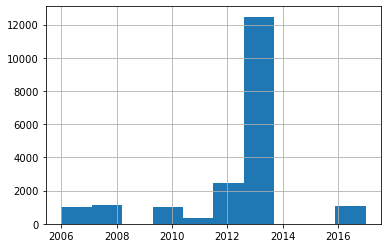

In [170]:
sstru_gdf = gpd.read_file(os.path.join(base_path, 'Shoreline', 'VA_sstru_2006_2019_uniqueID.shp'))
sstru_gdf['ss_name'] = sstru_gdf.STRUCTURE.apply(lambda x: rename_ss(x))
sstru_gdf['classid'] = sstru_gdf.ss_name.apply(lambda x: classid(x))


# From the distribution, most structure were digitized using 2013 and 2012 VABP images
sstru_gdf['img_year'].hist()

# Extracting structure from 2012 and 2013, since we have 2012 NAIP image available
ss_gdf = sstru_gdf[sstru_gdf['img_year'].isin([2012,2013])]

# buffer the structure with 1 meter to create polygon types
# ss_gdf['centroid'] = ss_gdf.centroid
ss_gdf['geometry'] = ss_gdf['geometry'].buffer(0.00002)



# Check on the distribution of each structure type, in case there is data imbalance issue (we do, solve this later)

structure_list = list(set(ss_gdf.STRUCTURE.to_list()))

for structure in structure_list:
    ss_size = ss_gdf[ss_gdf.STRUCTURE==structure].shape[0]
    print("The size of {} is {}".format(structure, ss_size))



In [171]:
glos_york_gdf = ss_gdf[(ss_gdf['COUNTY']=='Gloucester') | (ss_gdf['COUNTY']=='York')]

In [172]:
for structure in structure_list:
    s_size = glos_york_gdf[glos_york_gdf.STRUCTURE==structure].shape[0]
    print("The size of {} is {}".format(structure, s_size))

The size of Wharf is 1
The size of Bulkhead is 493
The size of Marina <50 slips is 24
The size of Groinfield is 63
The size of Unconventional is 90
The size of Marsh Toe Revetment is 84
The size of Dilapidated Bulkhead is 29
The size of Debris is 34
The size of Breakwater is 97
The size of Marina >50 slips is 6
The size of Riprap is 756
The size of Jetty is 11


In [173]:
structure_dict = {}

for i in structure_list:
    structure_dict[i] = "_".join(i.split(" "))

for value in structure_dict.values():
    
    (Path(base_path) / 'Shoreline' / 'Shoreline_infrastructure_classification' / value).mkdir(exist_ok=True, parents=True)


In [174]:
mask_val = {'breakwater':'1', 'bulkhead':'2', 'debris':'3', 
            'dil_bulkh':'4', 'groinfield': '5', 'jetty': '6', 
            'marinalon':'7', 'marinash': '8', 'msh_toe_revet': '9', 
            'riprap': '10', 'unconventional': '11', 'wharf':'12'}

In [175]:
# Processing NAIP images

img_tiles = gpd.read_file(os.path.join(base_path, "NAIP_tiles_index", "2012_VA_tiles.shp"))
tile_list = list(set(img_tiles.location.to_list()))

In [51]:

# Processing structures coded using 2012 and 2013 basemap

N = 256
num = 0

for tile in tile_list[3:4]:
    
    tile_path = Path(base_path) / 'NAIP' / 'VA_NAIP_2012_6308'/ '2012_VA' / tile
    
    print("------------------------------------------------------")
    
    print("Processing tile {}: ".format(tile_path))
    
    num += 1
    print("Image {}".format(str(num)))
    
    # Convert the geotiff to wgs-84
    # Re-project the tile to wgs-84 and save it
    wgs84_name = tile.split('.')[0] + '_wgs84.tif'
    wgs84_path = '/rapids/notebooks/sciclone/geograd/Miranda/VIMS/Shoreline/Image_tiles'
    wgs84_tiff = os.path.join(wgs84_path, wgs84_name) #Path(wgs84_path) / wgs84_name 

    if not os.path.isfile(wgs84_tiff):
        
        print("Re-project file {} to WGS-84".format(wgs84_tiff))
        
        re_projection(tile_path, wgs84_tiff, dst_crs=None)
    
    # select vectors that are within the tile
    tif_geom = get_tile_geom(wgs84_tiff)
    sub_ss = ss_gdf[ss_gdf.within(tif_geom)]

    # Check the vectors that overlayed with the selected tile
    if not sub_ss.empty:
        
        # Get the centroid point of the polygon, the center point will be used to cut the image window
        sub_ss['center_point'] = sub_ss.geometry.centroid
        sub_ss['lon'] = sub_ss.center_point.map(lambda p: p.x)
        sub_ss['lat'] = sub_ss.center_point.map(lambda p: p.y)
        
            
        # --------------------------
        # Start creating image patches

        with rasterio.open(wgs84_tiff) as dataset:

            for index, row in sub_ss.iterrows():
                
                print("Processing vector: {}".format(index))

                # Get pixel index (col, row)
                py, px = dataset.index(row['lon'], row['lat']) # row, col = dataset.index(x, y)

                # Build an N*N window
                window = rasterio.windows.Window(px - N//2, py - N//2, N, N) # Window(col_off, row_off, width, height)
                
                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)
                
                mask_array, outperform, _ = rasterio.mask.raster_geometry_mask(dataset, [row.geometry], invert=True)
                
                mask_array = np.where(mask_array == True, 1, 0)
                

                # You can then write out a new file
                meta = dataset.meta
                meta['width'], meta['height'] = N, N
                meta['transform'] = rasterio.windows.transform(window, dataset.transform)
                
                classid = mask_val[row['ss_name']]
                
#                 classname = structure_dict[row['STRUCTURE']]
#                 filename = str(row['unique_id']) + '.tif'
                # outfile = Path(base_path) / 'Shoreline' / 'Shoreline_infrastructure_classification' / classname / filename
                
                outfile = Path(base_path) / 'delete.tif'
                maskfile = Path(base_path) / 'delete_mask.tif'
                
                with rasterio.open(outfile, 'w', **meta) as dst:
                    dst.write(clip)

        
    

------------------------------------------------------
Processing tile /rapids/notebooks/sciclone/geograd/Miranda/VIMS/NAIP/VA_NAIP_2012_6308/2012_VA/m_3707645_sw_18_1_20120512.tif: 
Image 1
Processing vector: 7314


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/opt/conda/envs/rapids/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/rapids/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Processing vector: 7315
Processing vector: 7316
Processing vector: 7317
Processing vector: 7318
Processing vector: 7319
Processing vector: 7328
Processing vector: 7335
Processing vector: 7336


KeyboardInterrupt: 

In [200]:
N = 256

# testfile = Path(base_path) / 'Shoreline' / 'Shoreline_infrastructure_classification' / 'Groinfield' / '7314.tif'


for tile in tiles: 

    # select vectors that are within the tile
    tif_geom = get_tile_geom(tile)
    sub_ss = ss_gdf[ss_gdf.intersects(tif_geom)]

    sub_ss_group = sub_ss.groupby('classid')

    with rasterio.open(tile) as dataset:

        mask_array, outperform, _ = rasterio.mask.raster_geometry_mask(dataset, sub_ss.geometry.to_list(), invert=True)
        mask_array = np.multiply(mask_array, 1)


        for name, group in sub_ss_group:

            mask_class, outperform, _ = rasterio.mask.raster_geometry_mask(dataset, group.geometry.tolist(), invert=True)
            mask_class = np.multiply(mask_class, 1)

            mask_array = np.where(mask_class==1, int(name), mask_array)


    #         """
    #         This only create masks for the pixels exterior to the polygons
    #         """
    #         xnew = list()
    #         ynew = list()

    #         # get the exterior coordinates
    #         x, y = row.geometry.exterior.coords.xy
    #         x = list(x)
    #         y = list(y)

    #         for i in range(len(x)):

    #             r, c = dataset.index(x[i], y[i]) # row, col = dataset.index(x, y)
    #             xnew.append(r)
    #             ynew.append(c)

    #         xnew = filter_bound(xnew, threshold=N)
    #         ynew = filter_bound(ynew, threshold=N)

    #         rr, cc = skimage.draw.polygon(ynew, xnew)

    #         mask_array[xnew, ynew] = int(row.classid)

        mask_meta = dataset.meta.copy()
        mask_meta.update({'count': 1})
            
        maskname = Path(tile).stem + '_mask.tif'
        
        maskfile = Path(base_path) / maskname

        with rasterio.open(maskfile, 'w', **mask_meta) as dst:
            dst.write(mask_array, 1)


    

            
            
        


    
    
    
#     for index, row in sub_ss.iterrows():
                
#     print("Processing vector: {}".format(index))

#     # Get pixel index (col, row)
#     py, px = dataset.index(row['lon'], row['lat']) # row, col = dataset.index(x, y)

#     # Build an N*N window
#     window = rasterio.windows.Window(px - N//2, py - N//2, N, N) # Window(col_off, row_off, width, height)
                
#     # Read the data in the window
#     # clip is a nbands * N * N numpy array
#     clip = dataset.read(window=window)
                
#     mask_array, outperform, _ = rasterio.mask.raster_geometry_mask(dataset, [row.geometry], invert=True)
                
#     mask_array = np.where(mask_array == True, 1, 0)
                

#     # You can then write out a new file
#     meta = dataset.meta
#     meta['width'], meta['height'] = N, N
#     meta['transform'] = rasterio.windows.transform(window, dataset.transform)
                
#     classid = mask_val[row['ss_name']]
                
# #                 classname = structure_dict[row['STRUCTURE']]
# #                 filename = str(row['unique_id']) + '.tif'
#                 # outfile = Path(base_path) / 'Shoreline' / 'Shoreline_infrastructure_classification' / classname / filename
                
#     outfile = Path(base_path) / 'delete.tif'
#     maskfile = Path(base_path) / 'delete_mask.tif'
                
#     with rasterio.open(outfile, 'w', **meta) as dst:
        
#         dst.write(clip)

In [ ]:

# # Processing structures coded using 2012 and 2013 basemap

# N = 256
# num = 0

# for tile in tile_list:
    
#     tile_path = Path(base_path) / 'NAIP' / 'VA_NAIP_2012_6308'/ '2012_VA' / tile
    
#     print("------------------------------------------------------")
    
#     print("Processing tile {}: ".format(tile_path))
    
#     num += 1
#     print("Image {}".format(str(num)))
    
#     # Convert the geotiff to wgs-84
#     # Re-project the tile to wgs-84 and save it
#     wgs84_name = tile.split('.')[0] + '_wgs84.tif'
#     wgs84_path = '/rapids/notebooks/sciclone/geograd/Miranda/VIMS/Shoreline/Image_tiles'
#     wgs84_tiff = Path(wgs84_path) / wgs84_name

#     if not os.path.isdir(wgs84_tiff):
        
#         print("Re-project file {} to WGS-84".format(wgs84_tiff))
        
#         re_projection(tile_path, wgs84_tiff, dst_crs=None)
    
#     # select vectors that are within the tile
#     tif_geom = get_tile_geom(wgs84_tiff)
#     sub_ss = ss_gdf[ss_gdf.within(tif_geom)]

    
#     # Check the vectors that overlayed with the selected tile
#     if not sub_ss.empty:
        
#         # Get the centroid point of the polygon, the center point will be used to cut the image window
#         sub_ss['center_point'] = sub_ss.geometry.centroid
#         sub_ss['lon'] = sub_ss.center_point.map(lambda p: p.x)
#         sub_ss['lat'] = sub_ss.center_point.map(lambda p: p.y)
        
            
#         # --------------------------
#         # Start creating image patches

#         with rasterio.open(wgs84_tiff) as dataset:

#             for index, row in sub_ss.iterrows():
                
#                 print("Processing vector: {}".format(index))

#                 # Get pixel index (col, row)
#                 py, px = dataset.index(row['lon'], row['lat']) # row, col = dataset.index(x, y)

#                 # Build an N*N window
#                 window = rasterio.windows.Window(px - N//2, py - N//2, N, N) # Window(col_off, row_off, width, height)

#                 # Read the data in the window
#                 # clip is a nbands * N * N numpy array
#                 clip = dataset.read(window=window)

#                 # You can then write out a new file
#                 meta = dataset.meta
#                 meta['width'], meta['height'] = N, N
#                 meta['transform'] = rasterio.windows.transform(window, dataset.transform)
                
#                 classname = structure_dict[row['STRUCTURE']]
#                 filename = str(row['unique_id']) + '.tif'
#                 outfile = Path(base_path) / 'Shoreline' / 'Shoreline_infrastructure_classification' / classname / filename

#                 with rasterio.open(outfile, 'w', **meta) as dst:
#                     dst.write(clip)



        
        
    